In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from docplex.mp.model import Model
from docplex.mp.utils import DOcplexException

In [2]:
def shift_and_append(df, n):

    # Shift the DataFrame by n positions (downward)
    shifted_df = df.shift(n)
    
    # Collect the dropped values (the last n rows before the shift)
    dropped_values = df.iloc[:-n].reset_index(drop=True)
    
    # Replace the first n rows (now NaN) with the dropped values
    shifted_df.iloc[n:] = dropped_values.values
    
    return shifted_df

In [3]:
def shift_and_concat(df, shifts):

    c = pd.DataFrame()
    noise = np.random.normal(0, 0.01, (df.shape[0]))
    
    for s in shifts:
        shifted_df = shift_and_append(df, s)
        shifted_df = shifted_df + noise
        c = pd.concat([c, shifted_df], axis=1)
        noise += np.random.normal(0, 0.01, (df.shape[0]))
    c.columns = [f'{df.name}_{abs(s)}h' for s in shifts]
    return c

In [4]:
def optimize_energy(
    solar_profile, load_assignation, batt_cap=6.5, alpha_high=0.5, alpha_diff=0.8, load_smoothness=0.15
):

    alpha_low = 1 - alpha_high

    model = Model(name='self_sufficient_day')

    # Define the decision variables
    load_high = model.continuous_var_list(24, name='load_h', lb=0)
    load_low = model.continuous_var_list(24, name='load_l', lb=0)
    batt = model.continuous_var_list(24, name='batt', lb=-1, ub=1)
    soc = model.continuous_var_list(24, name='soc', lb=0, ub=1)

    # Add constraints
    total_generation = solar_profile.sum()

    # Energy balance
    for i in range(24):
        model.add_constraint(load_high[i] + load_low[i] + batt[i] * batt_cap == solar_profile[i])

    # Battery
    model.add_constraint(soc[0] == 0)  # Initial state of charge

    # Charge and discharge
    for i in range(1,24):
        model.add_constraint(soc[i] == (soc[i-1] + batt[i]))

    # Load assignation
    for i in range(24):
        if load_assignation[i] == 'none':
            model.add_constraint(load_high[i] == 0)
            model.add_constraint(load_low[i] == 0)
        elif load_assignation[i] == 'low':
            # model.add_constraint(load_low[i] <= alpha_low * total_generation)
            # model.add_constraint(load_low[i] <= proportion_high * total_generation)
            model.add_constraint(load_high[i] == 0)
        elif load_assignation[i] == 'high':
            # model.add_constraint(load_high[i] <= alpha_high * total_generation)
            # model.add_constraint(load_high[i] <= proportion_high * total_generation)
            model.add_constraint(load_low[i] == 0)

    # Conditions for high and low load
    model.add_constraint(model.sum(load_high) == alpha_high * total_generation)
    model.add_constraint(model.sum(load_low) == alpha_low * total_generation)
    model.add_constraint(model.max(load_high) * alpha_diff >= model.max(load_low))

    # Smoothness of the load

    for i in range(1, 24):
        model.add_constraint(
            model.abs((load_high[i] + load_low[i]) - (load_high[i-1] + load_low[i-1])) <= load_smoothness * total_generation
        )

    # Define the objective function
    obj = model.sum(load_high[i] + load_low[i] + batt[i] * batt_cap - solar_profile[i] for i in range(24))
    model.minimize(obj)

    # Solve the model

    model.solve(log_output=False)
    
    # Prepare solution
    
    sol = {
        'load': np.zeros(24),
        'batt': np.zeros(24),
        'soc': np.zeros(24)
    }

    try:

        for v in model.iter_continuous_vars():
            if v.name is not None:
                index = int(v.name.split('_')[-1])
                if v.name.startswith('load'):
                    sol['load_h'][index] += v.solution_value
                if v.name.startswith('batt'):
                    sol['batt'][index] = v.solution_value
                if v.name.startswith('soc'):
                    sol['soc'][index] = v.solution_value

    except DOcplexException as e:

        # print(f"DOcplexException: {e.message}")

        return sol, False

    return sol, True


In [5]:
def optimize_energy(
    solar_profile, load_assignation, batt_cap=6.5, alpha_high=0.5, alpha_diff=0.8, load_smoothness=0.15
):

    alpha_low = 1 - alpha_high

    model = Model(name='self_sufficient_day')

    # Define the decision variables
    net_energy = model.continuous_var_list(24, name='net', lb=-100, ub=100)
    load_high = model.continuous_var_list(24, name='load_h', lb=0)
    load_low = model.continuous_var_list(24, name='load_l', lb=0)
    batt_ch = model.continuous_var_list(24, name='batt_ch', lb=0, ub=1)
    batt_dch = model.continuous_var_list(24, name='batt_dch', lb=-1, ub=0)
    soc = model.continuous_var_list(24, name='soc', lb=0, ub=1)

    # Add constraints
    total_generation = solar_profile.sum()

    # Energy balance
    for i in range(24):
        # model.add_constraint(load_high[i] + load_low[i] + (batt_ch[i] + batt_dch[i]) * batt_cap == solar_profile[i])
        model.add_constraint(net_energy[i] == load_high[i] + load_low[i] + (batt_ch[i] + batt_dch[i]) * batt_cap - solar_profile[i])

    # Battery
    model.add_constraint(soc[0] == 0)  # Initial state of charge

    # Charge and discharge
    for i in range(1,24):
        model.add_constraint(soc[i] == (soc[i-1] + batt_ch[i] + batt_dch[i]))
        model.add_constraint(batt_ch[i] <= 1 - soc[i-1])
        model.add_constraint(model.abs(batt_dch[i]) <= soc[i-1])

    # Load assignation
    for i in range(24):
        if load_assignation[i] == 'none':
            model.add_constraint(load_high[i] == 0)
            model.add_constraint(load_low[i] == 0)
        elif load_assignation[i] == 'low':
            # model.add_constraint(load_low[i] <= alpha_low * total_generation)
            # model.add_constraint(load_low[i] <= proportion_high * total_generation)
            model.add_constraint(load_high[i] == 0)
        elif load_assignation[i] == 'high':
            # model.add_constraint(load_high[i] <= alpha_high * total_generation)
            # model.add_constraint(load_high[i] <= proportion_high * total_generation)
            model.add_constraint(load_low[i] == 0)

    # Conditions for high and low load
    model.add_constraint(model.sum(load_high) == alpha_high * total_generation)
    model.add_constraint(model.sum(load_low) == alpha_low * total_generation)
    model.add_constraint(model.max(load_high) * alpha_diff >= model.max(load_low))

    # Smoothness of the load

    for i in range(1, 24):
        model.add_constraint(
            model.abs((load_high[i] + load_low[i]) - (load_high[i-1] + load_low[i-1])) <= load_smoothness * total_generation
        )

    # Define the objective function
    obj = model.sum([model.max(net_energy[i], 0) for i in range(24)])
    model.minimize(obj)

    # Solve the model

    model.solve(log_output=False)
    
    # Prepare solution
    
    sol = {
        'load': np.zeros(24),
        'batt': np.zeros(24),
        'soc': np.zeros(24)
    }

    try:

        for v in model.iter_continuous_vars():
            if v.name is not None:
                index = int(v.name.split('_')[-1])
                if v.name.startswith('load'):
                    sol['load'][index] += v.solution_value
                if v.name.startswith('batt'):
                    sol['batt'][index] += v.solution_value
                if v.name.startswith('soc'):
                    sol['soc'][index] = v.solution_value

    except DOcplexException as e:

        # print(f"DOcplexException: {e.message}")

        return sol, False

    return sol, True


In [8]:
def optimize_energy(
    solar_profile, load_assignation, price, emissions, batt_cap=6.5, alpha_high=0.5, alpha_diff=0.8, load_smoothness=0.15,
    weight_emissions=0.6, cost_margin = 0.1
):

    alpha_low = 1 - alpha_high
    weight_price = 1 - weight_emissions
    sell_price = price * (1 - cost_margin)

    model = Model(name='self_sufficient_day')

    # Define the decision variables
    net_energy = model.continuous_var_list(24, name='net', lb=-100, ub=100)
    load_high = model.continuous_var_list(24, name='load_h', lb=0)
    load_low = model.continuous_var_list(24, name='load_l', lb=0)
    batt_ch = model.continuous_var_list(24, name='batt_ch', lb=0, ub=1)
    batt_dch = model.continuous_var_list(24, name='batt_dch', lb=-1, ub=0)
    soc = model.continuous_var_list(24, name='soc', lb=0, ub=1)

    # Add constraints
    total_generation = solar_profile.sum()

    # Energy balance
    for i in range(24):
        model.add_constraint(load_high[i] + load_low[i] + (batt_ch[i] + batt_dch[i]) * batt_cap == solar_profile[i])
        model.add_constraint(net_energy[i] == load_high[i] + load_low[i] + (batt_ch[i] + batt_dch[i]) * batt_cap - solar_profile[i])

    # Battery
    model.add_constraint(soc[0] == 0)  # Initial state of charge

    # Charge and discharge
    for i in range(1,24):
        model.add_constraint(soc[i] == (soc[i-1] + batt_ch[i] + batt_dch[i]))
        model.add_constraint(batt_ch[i] <= 1 - soc[i-1])
        model.add_constraint(model.abs(batt_dch[i]) <= soc[i-1])

    # Load assignation
    for i in range(24):
        if load_assignation[i] == 'none':
            model.add_constraint(load_high[i] == 0)
            model.add_constraint(load_low[i] == 0)
        elif load_assignation[i] == 'low':
            # model.add_constraint(load_low[i] <= alpha_low * total_generation)
            # model.add_constraint(load_low[i] <= proportion_high * total_generation)
            model.add_constraint(load_high[i] == 0)
        elif load_assignation[i] == 'high':
            # model.add_constraint(load_high[i] <= alpha_high * total_generation)
            # model.add_constraint(load_high[i] <= proportion_high * total_generation)
            model.add_constraint(load_low[i] == 0)

    # Conditions for high and low load
    model.add_constraint(model.sum(load_high) == alpha_high * total_generation)
    model.add_constraint(model.sum(load_low) == alpha_low * total_generation)
    model.add_constraint(model.max(load_high) * alpha_diff >= model.max(load_low))

    # Smoothness of the load

    for i in range(1, 24):
        model.add_constraint(
            model.abs((load_high[i] + load_low[i]) - (load_high[i-1] + load_low[i-1])) <= load_smoothness * total_generation
        )

    # Define the objective function
    obj = []
    
    for i in range(24):

        # obj += weight_price * price[i] * net_energy[i]
        obj.append(weight_price * price[i] * model.max(net_energy[i], 0)) 
        obj.append(weight_price * sell_price[i] * model.min(net_energy[i], 0))
        obj.append(weight_emissions * emissions[i] * model.max(net_energy[i], 0))

    model.minimize(model.sum(obj))

    # Solve the model

    model.solve(log_output=False)
    
    # Prepare solution
    
    sol = {
        'load': np.zeros(24),
        'batt': np.zeros(24),
        'soc': np.zeros(24),
        'net': np.zeros(24)
    }

    try:

        for v in model.iter_continuous_vars():
            if v.name is not None:
                index = int(v.name.split('_')[-1])
                if v.name.startswith('load'):
                    sol['load'][index] += v.solution_value
                if v.name.startswith('batt'):
                    sol['batt'][index] += v.solution_value
                if v.name.startswith('soc'):
                    sol['soc'][index] = v.solution_value
                if v.name.startswith('net'):
                    sol['net'][index] = v.solution_value

    except DOcplexException as e:

        # print(f"DOcplexException: {e.message}")

        return sol, False

    return sol, True


In [5]:
def optimize_energy(
    solar_profile, load_assignation, carbon_intensity, batt_cap=6.5, alpha_high=0.5, alpha_diff=0.8, load_smoothness=0.15
):

    alpha_low = 1 - alpha_high

    model = Model(name='self_sufficient_day')

    # Define the decision variables
    net_energy = model.continuous_var_list(24, name='net', lb=-100, ub=100)
    load_high = model.continuous_var_list(24, name='load_h', lb=0)
    load_low = model.continuous_var_list(24, name='load_l', lb=0)
    batt_ch = model.continuous_var_list(24, name='batt_ch', lb=0, ub=1)
    batt_dch = model.continuous_var_list(24, name='batt_dch', lb=-1, ub=0)
    soc = model.continuous_var_list(24, name='soc', lb=0, ub=1)

    # Add constraints
    total_generation = solar_profile.sum()

    # Energy balance
    for i in range(24):
        model.add_constraint(net_energy[i] == load_high[i] + load_low[i] + (batt_ch[i] + batt_dch[i]) * batt_cap - solar_profile[i])

    # Battery
    model.add_constraint(soc[0] == 0)  # Initial state of charge

    # Charge and discharge
    for i in range(1,24):
        model.add_constraint(soc[i] == (soc[i-1] + batt_ch[i] + batt_dch[i]))
        model.add_constraint(batt_ch[i] <= 1 - soc[i-1])
        model.add_constraint(model.abs(batt_dch[i]) <= soc[i-1])

    # Load assignation
    for i in range(24):
        if load_assignation[i] == 'none':
            model.add_constraint(load_high[i] == 0)
            model.add_constraint(load_low[i] == 0)
        elif load_assignation[i] == 'low':
            # model.add_constraint(load_low[i] <= alpha_low * total_generation)
            # model.add_constraint(load_low[i] <= proportion_high * total_generation)
            model.add_constraint(load_high[i] == 0)
        elif load_assignation[i] == 'high':
            # model.add_constraint(load_high[i] <= alpha_high * total_generation)
            # model.add_constraint(load_high[i] <= proportion_high * total_generation)
            model.add_constraint(load_low[i] == 0)

    # Conditions for high and low load
    model.add_constraint(model.sum(load_high) == alpha_high * total_generation)
    model.add_constraint(model.sum(load_low) == alpha_low * total_generation)
    model.add_constraint(model.max(load_high) * alpha_diff >= model.max(load_low))

    # Smoothness of the load

    for i in range(1, 24):
        model.add_constraint(
            model.abs((load_high[i] + load_low[i]) - (load_high[i-1] + load_low[i-1])) <= load_smoothness * total_generation
        )

    # Define the objective function
    obj = model.sum([model.max(net_energy[i], 0) * carbon_intensity[i] for i in range(24)])
    model.minimize(obj)

    # Solve the model

    model.solve(log_output=False)
    
    # Prepare solution
    
    sol = {
        'load': np.zeros(24),
        'batt': np.zeros(24),
        'soc': np.zeros(24)
    }

    try:

        for v in model.iter_continuous_vars():
            if v.name is not None:
                index = int(v.name.split('_')[-1])
                if v.name.startswith('load'):
                    sol['load'][index] += v.solution_value
                if v.name.startswith('batt'):
                    sol['batt'][index] += v.solution_value
                if v.name.startswith('soc'):
                    sol['soc'][index] = v.solution_value

    except DOcplexException as e:

        # print(f"DOcplexException: {e.message}")

        return sol, False

    return sol, True


In [9]:
def plot_energy_solution(sol, solar_generation, batt_cap=6.5):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    for i in range(1, len(sol['batt'])):
        
        b = sol['batt'][i]
        s = sol['soc'][i-1]
        
        if b > 0:
            sol['batt'][i] = min(b, 1 - s)
        else:
            sol['batt'][i] = max(b, -s)
            
    ax1.plot(sol['load'], label='Load', marker='o')
    ax1.plot(sol['batt'] * batt_cap, label='Battery energy', color='g', linestyle='--', marker='o')
    ax1.plot(solar_generation, label='Solar generation', marker='o')
    ax1.plot(sol['load'] + sol['batt'] * batt_cap - solar_generation, label='Total energy', color='m', linestyle='--', marker='o')

    ax2.plot(sol['soc'], label='State of charge', color='tab:red', marker='o')
    ax2.plot(sol['batt'], label='Battery action', color='tab:purple', marker='o')

    ax1.set_xlabel('Time (hours)')
    ax2.set_xlabel('Time (hours)')
    ax1.set_ylabel('Energy (kWh)')
    ax2.set_ylabel('State of Charge')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    ax1.grid()
    ax2.grid()

    ax1.set_xticks(range(0, 24))
    ax2.set_xticks(range(0, 24))

    plt.show()

Solved: False


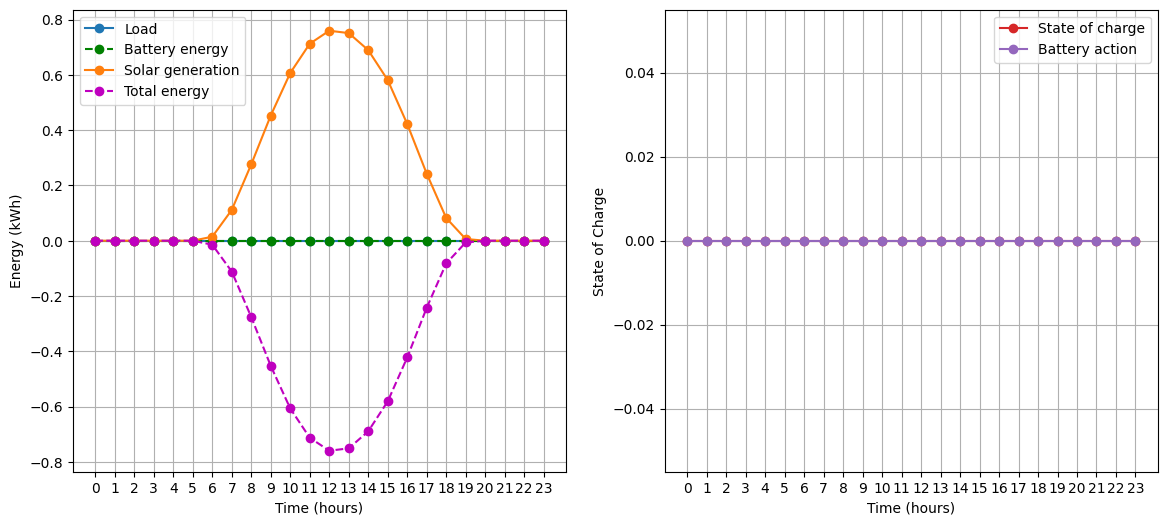

Solved: True


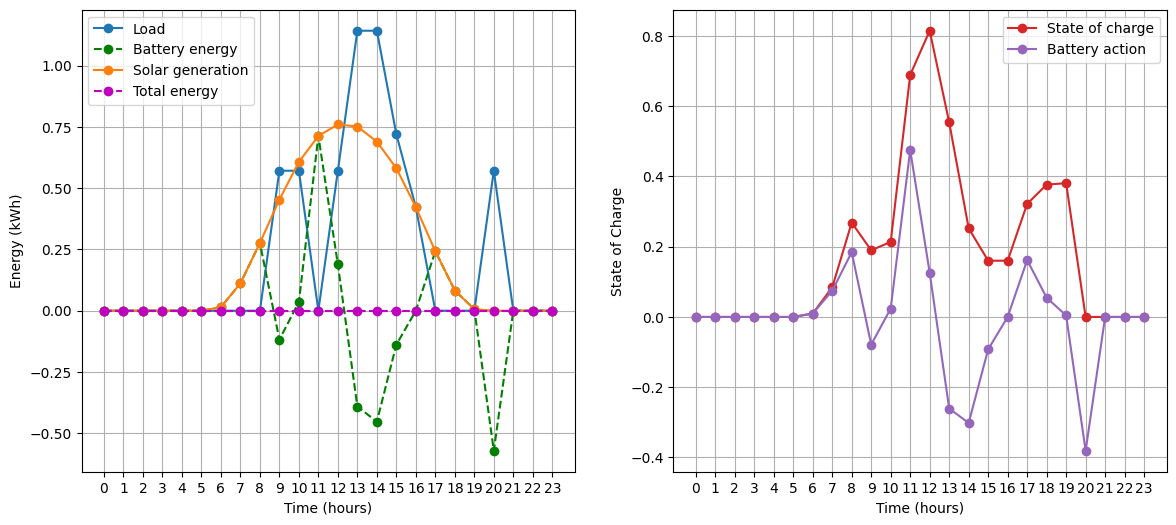

Solved: False


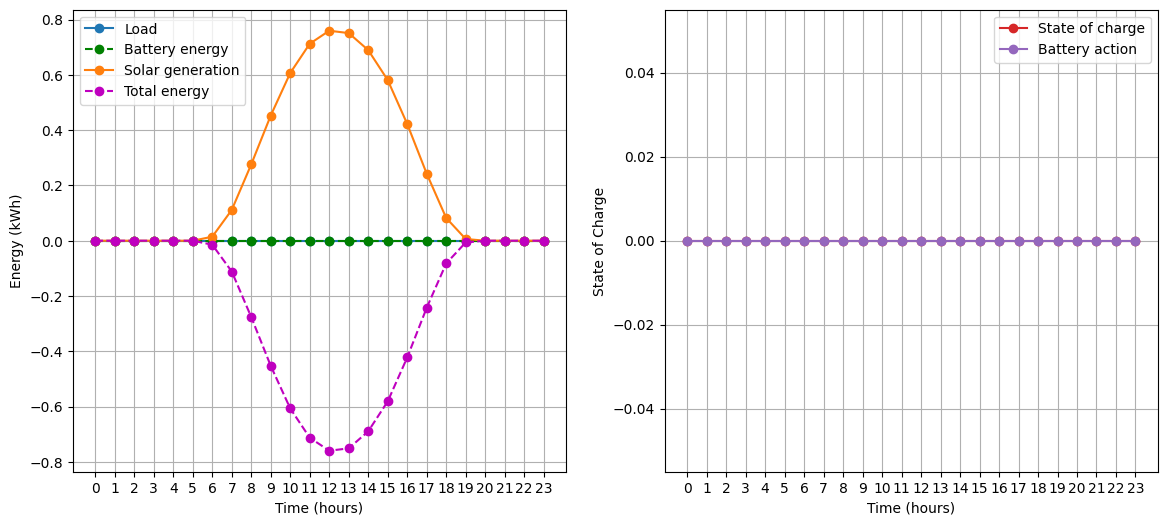

Solved: True


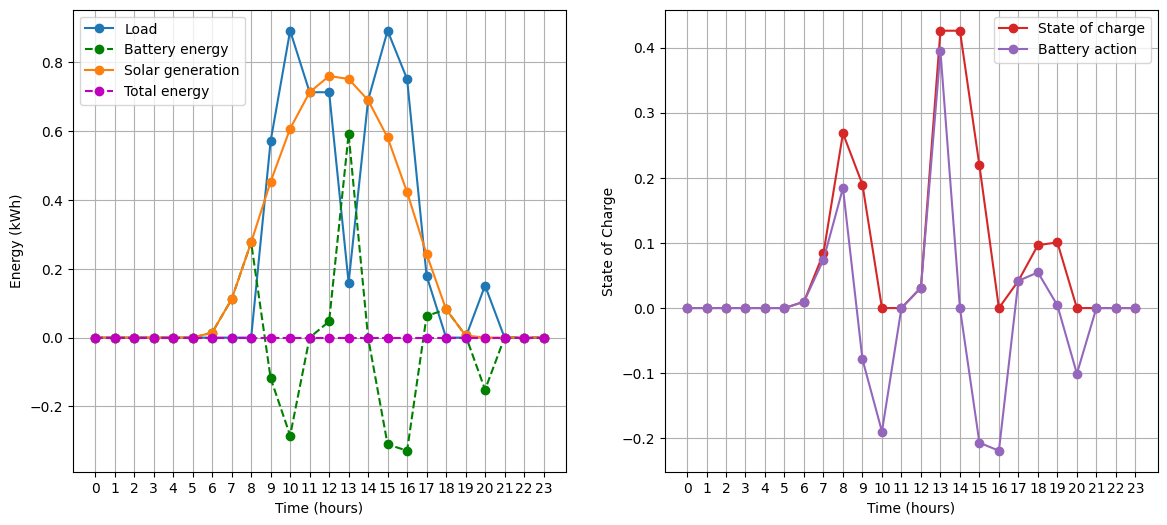

Solved: True


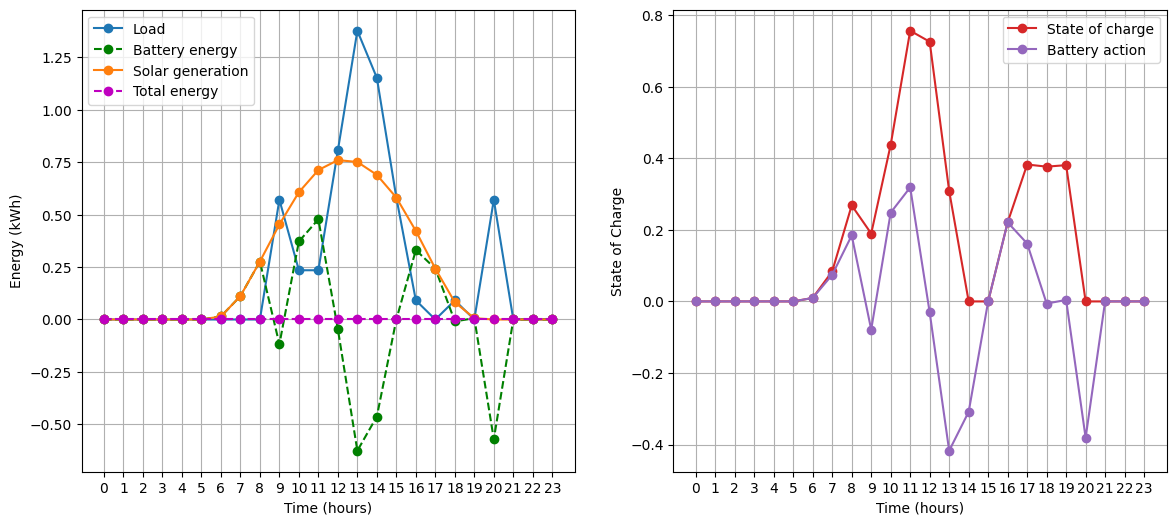

In [13]:
# Define solar energy generation values (in kWh) for each hour

solar_generation = np.array([0, 0, 0, 0, 0, 0, 0, 0.5, 1.5, 3.0, 4.5, 5.0, 4.8, 4.0, 3.0, 1.5, 0.5, 0.1, 0, 0, 0, 0, 0, 0]) * 200

# solar_generation = np.array([  0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
#           0.     ,  13.82083,  58.45417,  91.12083, 103.21667,  90.8125 ,
#          96.45834, 239.975  , 162.25833, 415.49167, 294.30417, 153.09166,
#          17.27917,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ])

# solar_generation = np.array([0.        , 0.        , 0.        , 0.        , 0.        ,
#        0.        , 0.        , 0.01382083, 0.05845417, 0.09112083,
#        0.10321667, 0.0908125 , 0.09645834, 0.239975  , 0.16225833,
#        0.41549167, 0.29430417, 0.15309166, 0.01727917, 0.        ,
#        0.        , 0.        , 0.        , 0.        ])

solar_generation = np.array([
    0.        , 0.        , 0.        , 0.        , 0.        ,
    0.        , 0.01450417, 0.11152084, 0.27647083, 0.453025  ,
    0.6069625 , 0.71275   , 0.759825  , 0.7512625 , 0.689675  ,
    0.581275  , 0.422425  , 0.2426    , 0.08224167, 0.00623333,
    0.        , 0.        , 0.        , 0.        
])

# solar_generation /= 1000

# Define an assignation of energy consumption by levels

price = np.array([
    0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21,
    0.21, 0.21, 0.21, 0.21, 0.21, 0.50, 0.50, 0.50, 0.50, 0.50, 0.21,
    0.21, 0.21
])

# price *= -10

emissions = np.array([
    0.13, 0.13, 0.13, 0.13, 0.13, 0.14, 0.16, 0.16, 0.16, 0.16, 0.16,
    0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.17, 0.17, 0.16, 0.16, 0.16,
    0.15, 0.13
])

load_assignations = np.array([
    ['none', 'none', 'none', 'low', 'low', 'low', 'high', 'none'],
    ['none', 'none', 'none', 'low', 'high', 'high', 'low', 'none'],
    ['none', 'none', 'none', 'high', 'low', 'low', 'high', 'none'],
    ['none', 'none', 'none', 'high', 'low', 'high', 'low', 'none'],
    ['none', 'none', 'none', 'low', 'high', 'low', 'high', 'none'],
])
batt_cap = 1.5

for load_assignation in load_assignations:

    load_assignation = np.array([[l] * 3 for l in load_assignation]).flatten()
    # sol, solved = optimize_energy(solar_generation, load_assignation, batt_cap=batt_cap, alpha_high=0.4)
    # sol, solved = optimize_energy(solar_generation, load_assignation, emissions, batt_cap=batt_cap, alpha_high=0.4)
    sol, solved = optimize_energy(
        solar_profile=solar_generation, load_assignation=load_assignation, price=price, emissions=emissions,
        batt_cap=batt_cap, alpha_high=0.7, weight_emissions=0.1, alpha_diff=0.9, load_smoothness=0.1)
    print(f'Solved: {solved}')
    plot_energy_solution(sol, solar_generation, batt_cap)

In [20]:
import os
import json
import random
import shutil

import numpy as np
import pandas as pd
from tqdm import tqdm

from pathlib import Path
from citylearn.data import DataSet

def generate_optimal_data_from_ref(
    base_dataset: str = 'citylearn_challenge_2022_phase_all', dest_folder: str = 'data/opt_data/', building_no: int = 5,
    load_assignations: list = None, batt_cap: float = 6.5, alpha_high: float = 0.5, alpha_diff: float = 0.8,
    load_smoothness: float = 0.15, weight_emissions: float = 0.1
):

    # If the directory exists, delete it and create the subfolders
    
    shutil.rmtree(dest_folder, ignore_errors=True)
    
    # Creat destination folder exists including the subfolders

    Path(dest_folder).mkdir(parents=True, exist_ok=True)

    # Get reference schema

    schema = DataSet.get_schema(base_dataset)

    # Reduce the number of buildings to 1

    schema['buildings'] = {f'Building_{i + 1}': schema['buildings'][f'Building_{i + 1}'] for i in range(building_no)}

    # Extract the base weather, emissions and pricing data (doesn't change among buildings)

    base_weather = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['weather']))
    base_pricing = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['pricing']))
    base_emissions = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['carbon_intensity']))

    # Read the base schema and process the json

    # We need just to store the load and optimal actions for each building
    # 0 - Load
    # 1 - Battery charge/discharge
    # 2 - SoC

    building_data = np.array([[[0.] * 3 for _ in range(365 * 24)] for _ in range(building_no)])
    base_csvs = []

    for building_no, (building_name, info) in enumerate(schema['buildings'].items()):

        # Create custom building CSVs

        base_csv = pd.read_csv(os.path.join(schema['root_directory'], info['energy_simulation']))
        solar_generation = base_csv['solar_generation'].values / 1000
        base_csvs.append(base_csv)

        random.seed(building_no)

        # Pass one day at a time the solar generation from the building data

        with tqdm(total=365, desc=f'Processing Building {building_no + 1}') as pbar:

            for day in tqdm(range(365), desc=f'Processing Building {building_no + 1}'):

                solved = False
                load_assignation_count = 0

                while solved is False and load_assignation_count < 100: 
                    
                    load_assignation = random.choice(load_assignations)

                    sol, solved = optimize_energy(
                        solar_profile=solar_generation[day * 24:(day + 1) * 24],
                        load_assignation=load_assignation,
                        price=base_pricing['electricity_pricing'].values[day * 24:(day + 1) * 24],
                        emissions=base_emissions['carbon_intensity'].values[day * 24:(day + 1) * 24],
                        batt_cap=batt_cap,
                        alpha_high=alpha_high,
                        alpha_diff=alpha_diff,
                        load_smoothness=load_smoothness,
                        weight_emissions=weight_emissions
                    )

                    building_data[building_no, day * 24:(day + 1) * 24, 0] += sol['load']
                    building_data[building_no, day * 24:(day + 1) * 24, 1] += sol['batt']
                    building_data[building_no, day * 24:(day + 1) * 24, 2] += sol['soc']

                    load_assignation_count += 1

                pbar.set_postfix({'day': day, 'solved': "yes" if solved else "no", 'attempt': load_assignation_count})

                pbar.update(1)

                if not solved:
                    print(f"Day {day} not solved after {load_assignation_count} attempts")
                    return

    # Update the base csv with the new data

    for building_no, (building_name, _) in enumerate(schema['buildings'].items()):

        base_csvs[building_no]['non_shiftable_load'] = building_data[building_no,:,0].clip(min=0)
        base_csvs[building_no].to_csv(os.path.join(dest_folder, f'{building_name}.csv'), index=False)

        # Save batt action and soc in a separate file to avoid issues loading CityLearn

        sol_csv = pd.DataFrame(columns=['batt', 'soc'], index=range(365 * 24))

        sol_csv['batt'] = building_data[building_no,:,1]
        sol_csv['soc'] = building_data[building_no,:,2]

        sol_csv.to_csv(os.path.join(dest_folder, f'sol_{building_name}.csv'), index=False)

        # Save predictions (synthetic) for the building

        shifts = [-4, -6, -12, -24] # 4, 6, 12, 24 hours in the future

        shift_and_concat(
            df=base_csvs[building_no]['non_shiftable_load'],
            shifts=shifts
        ).clip(lower=0).to_csv(os.path.join(dest_folder, f'pred_{building_name}.csv'), index=False)

        # Update the schema with the new paths

        schema['buildings'][building_name]['energy_simulation'] = f'{building_name}.csv'

        # Update the schema to guarantee no degradation in the battery efficiency

        schema['buildings'][building_name]['electrical_storage']['attributes'] = {
            "capacity": batt_cap,
            "efficiency": 1.0,
            "capacity_loss_coefficient": 0.0,
            "loss_coefficient": 0.0,
            "nominal_power": int(0.8 * batt_cap),
            "power_efficiency_curve": [[0, 1],[0.3, 1],[0.7, 1],[0.8, 1],[1, 1]],
            "capacity_power_curve": [[0.0, 1],[0.8, 1],[1.0, 1]],
        }

        # Set nominal power to 1 for solar panel to simplify case

        schema['buildings'][building_name]['pv']['attributes']['nominal_power'] = 1.0

    # Write pricing and emissions data to the destination folder

    base_weather.to_csv(os.path.join(dest_folder, 'weather.csv'), index=False)
    base_pricing.to_csv(os.path.join(dest_folder, 'pricing.csv'), index=False)
    base_emissions.to_csv(os.path.join(dest_folder, 'carbon_intensity.csv'), index=False)

    # Save the new schema in the destination folder

    schema['root_directory'] = dest_folder

    with open(os.path.join(dest_folder, 'schema.json'), 'w') as f:
        json.dump(schema, f, indent=4)


In [18]:
from itertools import product

def generate_load_assignations(window_length: int = 5):

    load_assignations = []

    options = ['none', 'low', 'high']

    combinations = list(product(options, repeat=window_length))
    base = ['none'] * (8 - window_length)

    for c in combinations:
        load_assignations.append(base + list(c))
    
    return load_assignations


In [22]:
# Define an assignation of energy consumption by levels

load_assignations = generate_load_assignations(window_length=5)

for ix, load_assignation in enumerate(load_assignations):

    load_assignations[ix] = np.array([[l] * 3 for l in load_assignation]).flatten()

load_assignations = np.array(load_assignations)

generate_optimal_data_from_ref(
    load_assignations=load_assignations, batt_cap=3.0, alpha_high=0.2, alpha_diff=0.4, load_smoothness=0.4, building_no=2
)
    

Processing Building 1:   4%|▍         | 16/365 [01:42<37:06,  6.38s/it, day=15, solved=no, attempt=100]

Day 15 not solved after 100 attempts


In [1]:
# Check data generated picking random days from random buildings

day_index = 4302#6853 - 12
building_index = 0

with open('data/opt_data/schema.json', 'r') as f:
    schema = json.load(f)

building_name = f'Building_{building_index + 1}'
building_csv = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings'][building_name]['energy_simulation']))
sol_csv = pd.read_csv(os.path.join(schema['root_directory'], f'sol_{building_name}.csv'))

solar_generation = building_csv['solar_generation'].values / 1000
load = building_csv['non_shiftable_load'].values
batt = sol_csv['batt'].values
soc = sol_csv['soc'].values
battery_capacity = schema['buildings'][building_name]['electrical_storage']['attributes']['capacity']

plot_energy_solution({
    'load': load[day_index:day_index + 24],
    'batt': batt[day_index:day_index + 24],
    'soc': soc[day_index:day_index + 24]
}, solar_generation[day_index:day_index + 24], battery_capacity)

FileNotFoundError: [Errno 2] No such file or directory: 'data/opt_data/schema.json'

In [28]:
# Check net energy of whole year

with open('data/opt_data/schema.json', 'r') as f:
    schema = json.load(f)

for b_ix in range(len(schema['buildings'])):

    building_name = f'Building_{b_ix + 1}'
    building_csv = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings'][building_name]['energy_simulation']))
    sol_csv = pd.read_csv(os.path.join(schema['root_directory'], f'sol_{building_name}.csv'))

    solar_generation = building_csv['solar_generation'].values / 1000
    load = building_csv['non_shiftable_load'].values
    batt = sol_csv['batt'].values
    soc = sol_csv['soc'].values
    battery_capacity = schema['buildings'][building_name]['electrical_storage']['attributes']['capacity']

    # Compute net electricity

    net_energy_no_batt = load - solar_generation
    net_energy = load - solar_generation + batt * battery_capacity

    # Compute energy cost

    pricing = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['pricing']))['electricity_pricing'].values
    
    cost_no_batt = (net_energy_no_batt.clip(min=0) * pricing + net_energy_no_batt.clip(max=0) * 0.9 * pricing).sum()
    cost = (net_energy.clip(min=0) * pricing + net_energy.clip(max=0) * 0.9 * pricing).sum()

    # Compute carbon intensity

    emissions = pd.read_csv(os.path.join(schema['root_directory'], 'carbon_intensity.csv'))['carbon_intensity'].values

    emissions_no_batt = (emissions * net_energy_no_batt.clip(min=0)).sum()
    emissions = (emissions * net_energy.clip(min=0)).sum()

    print(f'Building {b_ix + 1}')
    print(f'Avg. Hour Cost No batt: {cost_no_batt} - With batt: {cost}')
    print(f'Avg. Hour Emissions No batt: {emissions_no_batt} - With batt: {emissions}')

Building 1
Avg. Hour Cost No batt: 69.36255987477452 - With batt: -42.34593041594142
Avg. Hour Emissions No batt: 120.36664494986393 - With batt: 15.353933592732432
Building 2
Avg. Hour Cost No batt: 23.085040885259115 - With batt: -34.994875970591394
Avg. Hour Emissions No batt: 86.5297438886129 - With batt: 0.03527674510603839


In [34]:
for i, n in enumerate(net_energy):

    if n == -0.7720958:
        print(i)

6853


In [16]:
# Check net energy for a given period

day_index = 5832

with open('data/opt_data/schema.json', 'r') as f:
    schema = json.load(f)

for b_ix in range(len(schema['buildings'])):

    building_name = f'Building_{b_ix + 1}'
    building_csv = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings'][building_name]['energy_simulation']))
    sol_csv = pd.read_csv(os.path.join(schema['root_directory'], f'sol_{building_name}.csv'))

    solar_generation = building_csv['solar_generation'].values[day_index:day_index+24] / 1000
    load = building_csv['non_shiftable_load'].values[day_index:day_index+24]
    batt = sol_csv['batt'].values[day_index:day_index+24]
    soc = sol_csv['soc'].values[day_index:day_index+24]
    battery_capacity = schema['buildings'][building_name]['electrical_storage']['attributes']['capacity']

    # Compute net electricity

    net_energy_no_batt = load - solar_generation
    net_energy = load - solar_generation + batt * battery_capacity

    # Compute energy cost

    pricing = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['pricing']))['electricity_pricing'].values[day_index:day_index+24]
    
    cost_no_batt = (net_energy_no_batt.clip(min=0) * pricing + net_energy_no_batt.clip(max=0) * 0.9 * pricing).sum()
    cost = (net_energy.clip(min=0) * pricing).sum() + (net_energy.clip(max=0) * 0.9 * pricing).sum()

    # Compute carbon intensity

    emissions = pd.read_csv(os.path.join(schema['root_directory'], 'carbon_intensity.csv'))['carbon_intensity'].values[day_index:day_index+24]

    emissions_no_batt = (emissions * net_energy_no_batt.clip(min=0)).sum()
    emissions = (emissions * net_energy.clip(min=0)).sum()

    print(f'Building {b_ix + 1}')
    print(f'Avg. Hour Cost No batt: {cost_no_batt} - With batt: {cost}')
    print(f'Avg. Hour Emissions No batt: {emissions_no_batt.mean()} - With batt: {emissions.mean()}')

Building 1
Avg. Hour Cost No batt: 0.4377617611672672 - With batt: 0.016644663281337263
Avg. Hour Emissions No batt: 0.5186821884252926 - With batt: 0.1285788938634842
Building 2
Avg. Hour Cost No batt: 0.22650196163711997 - With batt: -7.059630657835214e-17
Avg. Hour Emissions No batt: 0.31976998861492567 - With batt: 8.729224988679451e-17


In [35]:
# Check net energy for a given period

day_index = 5832

with open('data/opt_data/schema.json', 'r') as f:
    schema = json.load(f)

for b_ix in range(len(schema['buildings'])):

    building_name = f'Building_{b_ix + 1}'
    building_csv = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings'][building_name]['energy_simulation']))
    sol_csv = pd.read_csv(os.path.join(schema['root_directory'], f'sol_{building_name}.csv'))

    solar_generation = building_csv['solar_generation'].values[day_index:day_index+24] / 1000
    load = building_csv['non_shiftable_load'].values[day_index:day_index+24]
    batt = sol_csv['batt'].values[day_index:day_index+24]
    soc = sol_csv['soc'].values[day_index:day_index+24]
    battery_capacity = schema['buildings'][building_name]['electrical_storage']['attributes']['capacity']

    # Compute net electricity

    net_energy_no_batt = load - solar_generation
    net_energy = load - solar_generation + batt * battery_capacity

    # Compute energy cost

    pricing = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['pricing']))['electricity_pricing'].values[day_index:day_index+24]
    
    cost_no_batt = (net_energy_no_batt * pricing).sum()
    cost = (net_energy * pricing).sum()

    # Correct energy cost

    correct_cost_no_batt = (net_energy_no_batt.clip(min=0) * pricing + net_energy_no_batt.clip(max=0) * 0.9 * pricing).sum()
    correct_cost = (net_energy.clip(min=0) * pricing + net_energy.clip(max=0) * 0.9 * pricing).sum()

    # Compute carbon intensity

    emissions = pd.read_csv(os.path.join(schema['root_directory'], 'carbon_intensity.csv'))['carbon_intensity'].values[day_index:day_index+24]

    emissions_no_batt = (emissions * net_energy_no_batt.clip(min=0)).sum()
    emissions = (emissions * net_energy.clip(min=0)).sum()

    print(f'Building {b_ix + 1}')
    print(f'Avg. Hour Cost No batt: {cost_no_batt} - With batt: {cost}')
    print(f'Avg. Hour Correct Cost No batt: {correct_cost_no_batt} - With batt: {correct_cost}')
    print(f'Avg. Hour Emissions No batt: {emissions_no_batt} - With batt: {emissions}')

Building 1
Avg. Hour Cost No batt: 0.3715736714915346 - With batt: 2.636779683484747e-16
Avg. Hour Correct Cost No batt: 0.4377617611672672 - With batt: 0.016644663281337263
Avg. Hour Emissions No batt: 0.5186821884252926 - With batt: 0.1285788938634842
Building 2
Avg. Hour Cost No batt: 0.1784351461344002 - With batt: -6.187411694114076e-16
Avg. Hour Correct Cost No batt: 0.22650196163712022 - With batt: -5.545355841185541e-16
Avg. Hour Emissions No batt: 0.3196286961217151 - With batt: 1.825650186582095e-17


# Validation data from convex combination of houses

In [36]:
def convex_combination_of_df(df1, df2, alpha):

    comb = df1 * alpha + df2 * (1 - alpha)
    comb = comb.astype(df1.dtypes)

    return comb

In [37]:
import shutil

def create_eval_data_from_ref(ref_dir: str = 'data/opt_data/'):

    # Get schema file

    with open(os.path.join(ref_dir, 'schema.json'), 'r') as f:
        schema = json.load(f)

    # Read the original files in folder

    pred_files = []

    for csv_file in sorted(Path(ref_dir).glob("pred_*.csv")):
                    
        df = pd.read_csv(csv_file)
        pred_files.append(df)

    building_files = []

    for csv_file in sorted(Path(ref_dir).glob("Building_*.csv")):
                    
        df = pd.read_csv(csv_file)
        building_files.append(df)

    sol_files = []

    for csv_file in sorted(Path(ref_dir).glob("sol_*.csv")):
                    
        df = pd.read_csv(csv_file)
        sol_files.append(df)

    alpha = 0.4
    combinations = []

    for i in range(len(schema['buildings'])):

        # Pick two random buildings

        building_a, building_b = np.random.choice(len(schema['buildings']), 2, replace=False)

        combinations.append((building_a, building_b))

        # Convex combination of the predictions

        pred_1 = pred_files[building_a]
        pred_2 = pred_files[building_b]

        pred = convex_combination_of_df(pred_1, pred_2, alpha)

        # Convex combination of the solutions

        sol_1 = sol_files[building_a]
        sol_2 = sol_files[building_b]

        sol = convex_combination_of_df(sol_1, sol_2, alpha)

        # Convex combination of the buildings, but excluding the columns that should not be combined

        building_1 = building_files[building_a]
        building_2 = building_files[building_b]

        building = convex_combination_of_df(building_1, building_2, alpha)

        # Save the new files in the eval subfolder, first check that the folder exists

        Path(os.path.join(ref_dir, 'eval')).mkdir(parents=True, exist_ok=True)

        pred.to_csv(os.path.join(ref_dir, 'eval', f'pred_Building_{i + 1}.csv'), index=False)
        building.to_csv(os.path.join(ref_dir, 'eval', f'Building_{i + 1}.csv'), index=False)
        sol.to_csv(os.path.join(ref_dir, 'eval', f'sol_Building_{i + 1}.csv'), index=False)

    # Modify the schema to point to the new files

    schema['root_directory'] = os.path.join(ref_dir, 'eval')

    # Save schema

    with open(os.path.join(ref_dir, 'eval', 'schema.json'), 'w') as f:
        json.dump(schema, f, indent=4)

    # Save the rest of relevant files

    for file in ['weather.csv', 'pricing.csv', 'carbon_intensity.csv']:
        shutil.copyfile(os.path.join(ref_dir, file), os.path.join(ref_dir, 'eval', file))

    return combinations, pred_files, building_files, sol_files

combinations, pred_files, building_files, sol_files = create_eval_data_from_ref()

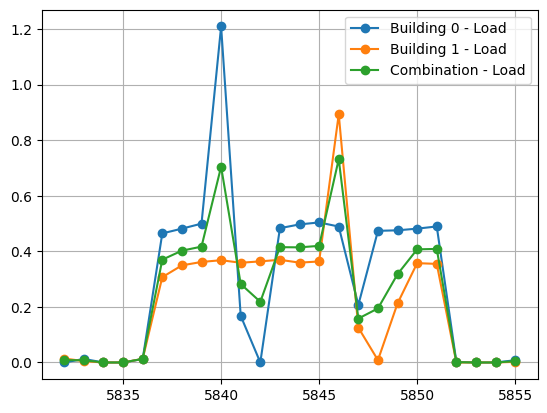

In [38]:
# Compare in a plot the convex combination of the predictions with the prediction of the convex combination for a given day

day_index = 5832
building_index = 1

b1, b2 = combinations[building_index]

pred_1 = pred_files[b1]
pred_2 = pred_files[b2]

# Read the combination from csv

comb = pd.read_csv(f'data/opt_data/eval/pred_Building_{building_index + 1}.csv')

plt.plot(pred_1['non_shiftable_load_4h'][day_index:day_index + 24], label=f'Building {b1} - Load', marker='o')
plt.plot(pred_2['non_shiftable_load_4h'][day_index:day_index + 24], label=f'Building {b2} - Load', marker='o')
plt.plot(comb['non_shiftable_load_4h'][day_index:day_index + 24], label='Combination - Load', marker='o')

plt.legend()
plt.grid()
plt.show()

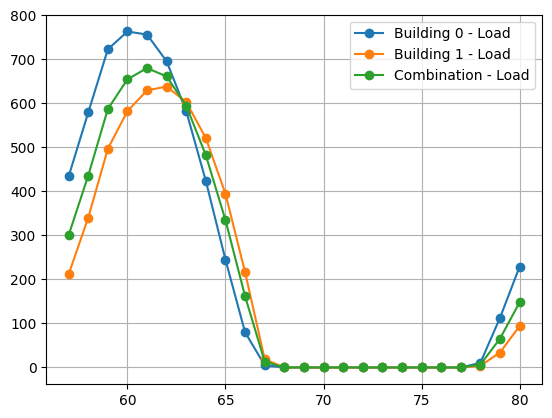

In [39]:
# Compare in a plot the convex combination of the buildings with the building of the convex combination for a given day

day_index = 57

b1, b2 = combinations[building_index]

building_1 = building_files[b1]
building_2 = building_files[b2]

# Read the combination from csv

comb = pd.read_csv(f'data/opt_data/eval/Building_{building_index + 1}.csv')

plt.plot(building_1['solar_generation'][day_index:day_index + 24], label=f'Building {b1} - Load', marker='o')
plt.plot(building_2['solar_generation'][day_index:day_index + 24], label=f'Building {b2} - Load', marker='o')
plt.plot(comb['solar_generation'][day_index:day_index + 24], label='Combination - Load', marker='o')

plt.legend()
plt.grid()
plt.show()

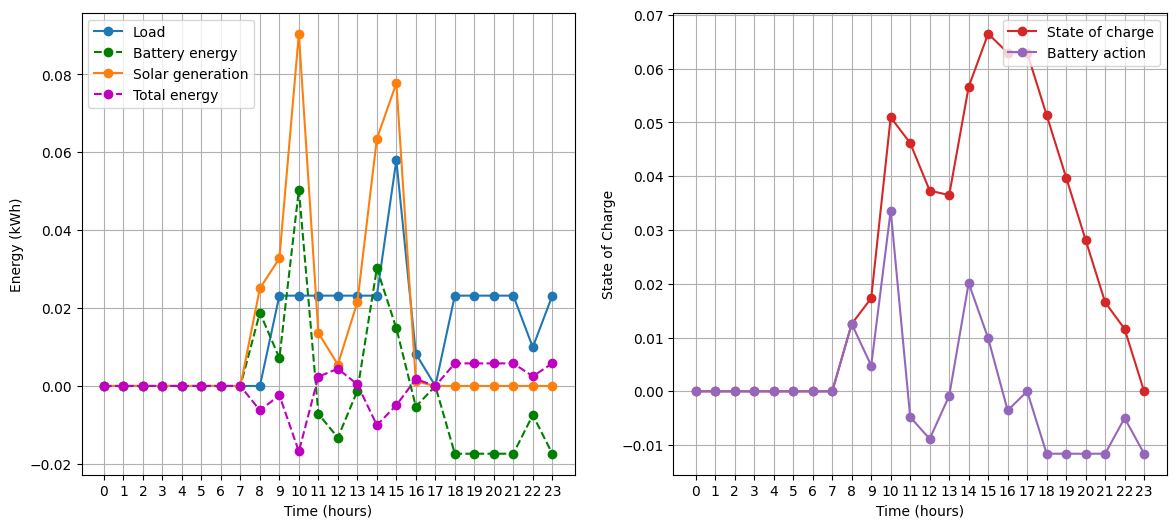

In [40]:
# Check data generated picking random days from random buildings

day_index = 4128
building_index = 0

comb = pd.read_csv(f'data/opt_data/eval/Building_{building_index + 1}.csv')
sol = pd.read_csv(f'data/opt_data/eval/sol_Building_{building_index + 1}.csv')

plot_energy_solution({
    'load': comb['non_shiftable_load'].values[day_index:day_index + 24],
    'batt': sol['batt'].values[day_index:day_index + 24],
    'soc': sol['soc'].values[day_index:day_index + 24]
}, comb['solar_generation'].values[day_index:day_index + 24] / 1000, batt_cap=1.5)

In [54]:
pd.read_csv(f'data/opt_data/sol_{building_name}.csv').head(24)

,batt,soc
0,-1.000000,0.000000
1,0.000000,0.000000
2,0.000000,0.000000
3,0.912092,0.912092
4,0.000000,0.912092
5,0.000000,0.912092
6,0.003739,0.915831
7,0.019667,0.935497
8,0.064503,1.000000
9,-0.232048,0.767952


In [55]:
sol['soc'].values[day_index:day_index + 24]

array([0.        , 0.        , 0.        , 0.95662022, 0.95662022,
       0.95662022, 0.95662022, 0.95662022, 0.97334022, 0.96572704,
       0.99657274, 0.97620956, 0.95042526, 0.93532041, 0.97762763,
       1.        , 1.        , 1.        , 0.6160936 , 0.00368151,
       0.        , 0.        , 0.        , 0.        ])

In [56]:
sol['batt'].values[day_index:day_index + 24]

array([-1.        ,  0.        ,  0.        ,  0.95662022,  0.        ,
        0.        ,  0.        ,  0.        ,  0.01672   , -0.00761319,
        0.0308457 , -0.02036318, -0.0257843 , -0.01510485,  0.04230722,
        0.02237237,  0.        ,  0.        , -0.3839064 , -0.61241209,
       -0.00368151,  0.        ,  0.        ,  0.        ])

In [57]:
comb['non_shiftable_load'].values[day_index:day_index + 24]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.04417811,
       0.04417811, 0.04417811, 0.04417811, 0.04417811, 0.        ,
       0.04417811, 0.        , 0.        , 0.00552226, 0.05522264,
       0.00552226, 0.        , 0.        , 0.        ])

In [58]:
comb['solar_generation'].values[day_index:day_index + 24] / 1000

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02508   , 0.03275833,
       0.09044666, 0.01363333, 0.00550167, 0.02152083, 0.06346083,
       0.07773667, 0.0011975 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])